In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [2]:
# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Step 1: Define CBAM Modules
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

    def forward(self, x):
        avg_out = self.fc2(F.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(F.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return torch.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


In [4]:
# Step 2: Define ResNet-50 with CBAM for Feature Extraction
class ResNet50_CBAM(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50_CBAM, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove last FC layer

        # Add CBAM after feature extraction part of ResNet
        self.cbam = CBAM(in_planes=2048)  # ResNet-50's last layer has 2048 feature maps

        # Global Average Pooling to reduce to 1x1 feature map per feature
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.resnet(x)  # Extract features from ResNet-50
        x = self.cbam(x)    # Apply CBAM
        x = self.gap(x)     # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 2048)
        return x

In [5]:
# Instantiate model and load to device
model = ResNet50_CBAM().to(device)


C:\Users\C RISHI VARDHAN REDD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\C RISHI VARDHAN REDD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
class_names = ["0p", "1p", "2p", "3p", "4p"]  # Modify according to your actual class names

# Define transform for input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Step 3: Prediction and Grad-CAM Block
def predict_image(image_path, model, svm, device, transform, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Extract features
    model.eval()
    with torch.no_grad():
        features = model(image_tensor)
    features = features.cpu().numpy()

    # Predict the class with SVM
    predicted_class = svm.predict(features)[0]
    print(f"Predicted Class: {class_names[predicted_class]}")

    # Generate Grad-CAM
    grad_cam = generate_gradcam(model, image_tensor, predicted_class)  # Pass the integer class index

    return grad_cam, class_names[predicted_class]

def generate_gradcam(model, image_tensor, target_class):
    # Set hooks to access the gradients
    grad = None
    def backward_hook(module, grad_in, grad_out):
        nonlocal grad
        grad = grad_out[0]
    
    forward_feature = None
    def forward_hook(module, input, output):
        nonlocal forward_feature
        forward_feature = output
    
    # Attach hooks to the last convolutional layer
    layer = model.resnet[-1]
    hook_handle_grad = layer.register_backward_hook(backward_hook)
    hook_handle_forward = layer.register_forward_hook(forward_hook)

    # Perform forward pass and backward pass
    model.eval()
    output = model(image_tensor)
    class_idx = target_class
    loss = output[:, class_idx].sum()
    loss.backward()

    # Remove hooks
    hook_handle_grad.remove()
    hook_handle_forward.remove()

    # Generate Grad-CAM
    features = forward_feature.detach()
    grad = grad.detach()
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)
    grad_cam = torch.sum(weights * features, dim=1).squeeze()
    grad_cam = torch.clamp(grad_cam, min=0).detach().cpu().numpy()
    grad_cam = cv2.resize(grad_cam, (224, 224))
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-5)
    
    return grad_cam


# Visualization function
def plot_gradcam(image_path, grad_cam, class_name):
    # Open the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    
    # Overlay Grad-CAM on the image
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)
    
    # Display the result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM for Predicted Class: {class_name}")
    plt.axis('off')
    plt.show()


In [7]:
# Step 3: Data Loading and Preprocessing
# Define directories for training and testing datasets
train_data_dir = r'C:\Users\C RISHI VARDHAN REDD\Desktop\osteoathritispp\trainpp'  # Folder containing training data with 5 subclasses
test_data_dir = r'C:\Users\C RISHI VARDHAN REDD\Desktop\osteoathritispp\testppp'  # Folder containing separate test data

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=data_transforms['test'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [8]:
# Step 4: Feature Extraction for Training and Testing Sets
model.eval()
features_train, labels_train = [], []
features_test, labels_test = [], []

# Extract features for training set
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features_train.extend(outputs.cpu().numpy())
        labels_train.extend(labels.cpu().numpy())

# Extract features for test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features_test.extend(outputs.cpu().numpy())
        labels_test.extend(labels.cpu().numpy())

# Convert to arrays
features_train = np.array(features_train)
labels_train = np.array(labels_train)
features_test = np.array(features_test)
labels_test = np.array(labels_test)


In [9]:
# Step 5: Train and Evaluate SVM Classifier
# Train SVM with training features
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(features_train, labels_train)


SVC(kernel='linear', random_state=42)

In [10]:
# Predict on the test features
y_pred = svm.predict(features_test)
print("Accuracy on Test Data:", accuracy_score(labels_test, y_pred))
print("Classification Report on Test Data:\n", classification_report(labels_test, y_pred))


Accuracy on Test Data: 0.6014
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01      1000
           1       0.59      1.00      0.74      1000
           2       0.72      1.00      0.83      1000
           3       0.53      1.00      0.69      1000
           4       0.46      0.01      0.01      1000

    accuracy                           0.60      5000
   macro avg       0.66      0.60      0.46      5000
weighted avg       0.66      0.60      0.46      5000



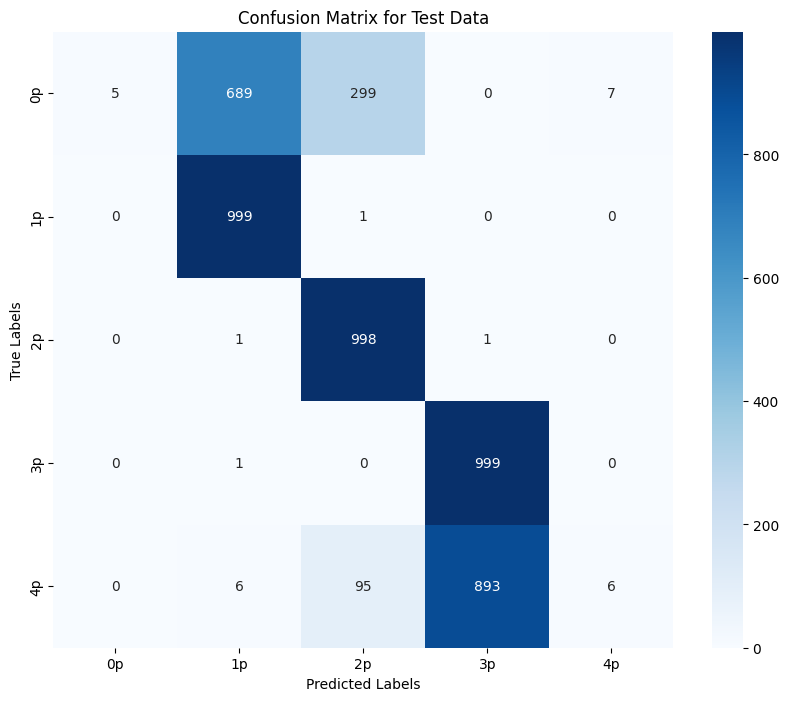

In [11]:
# Confusion Matrix for test data
cm = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Test Data")
plt.show()

Accuracy: 0.6014
Precision: 0.6589
Recall: 0.6014
F1 Score: 0.4575

Classification Report:
               precision    recall  f1-score   support

          0p       1.00      0.01      0.01      1000
          1p       0.59      1.00      0.74      1000
          2p       0.72      1.00      0.83      1000
          3p       0.53      1.00      0.69      1000
          4p       0.46      0.01      0.01      1000

    accuracy                           0.60      5000
   macro avg       0.66      0.60      0.46      5000
weighted avg       0.66      0.60      0.46      5000



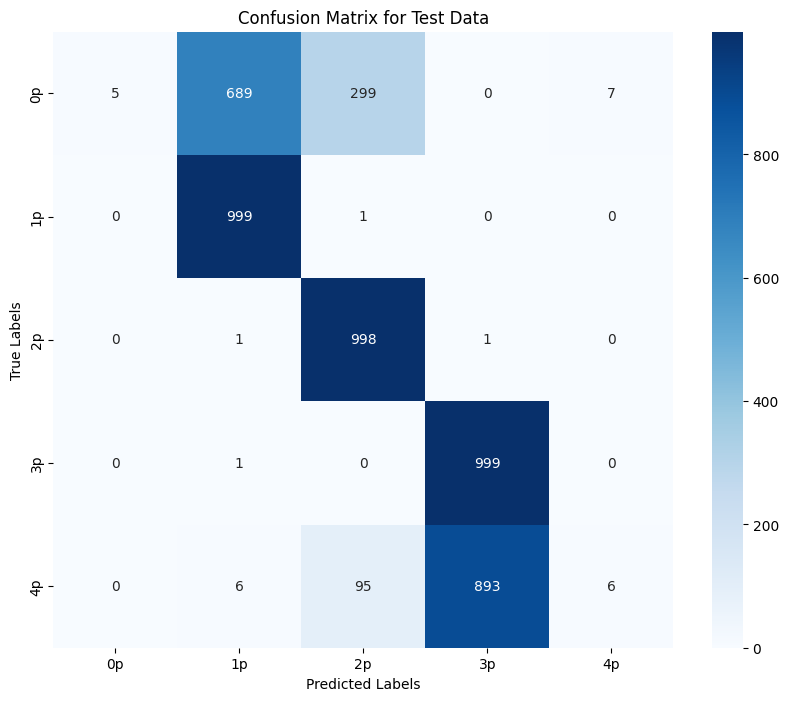

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Calculate Accuracy
accuracy = accuracy_score(labels_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision, Recall, F1-Score
precision = precision_score(labels_test, y_pred, average='weighted')
recall = recall_score(labels_test, y_pred, average='weighted')
f1 = f1_score(labels_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display Classification Report
print("\nClassification Report:\n", classification_report(labels_test, y_pred, target_names=test_dataset.classes))

# Compute and plot Confusion Matrix
confusion_mat = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Test Data")
plt.show()


Predicted Class: 0p


C:\Users\C RISHI VARDHAN REDD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


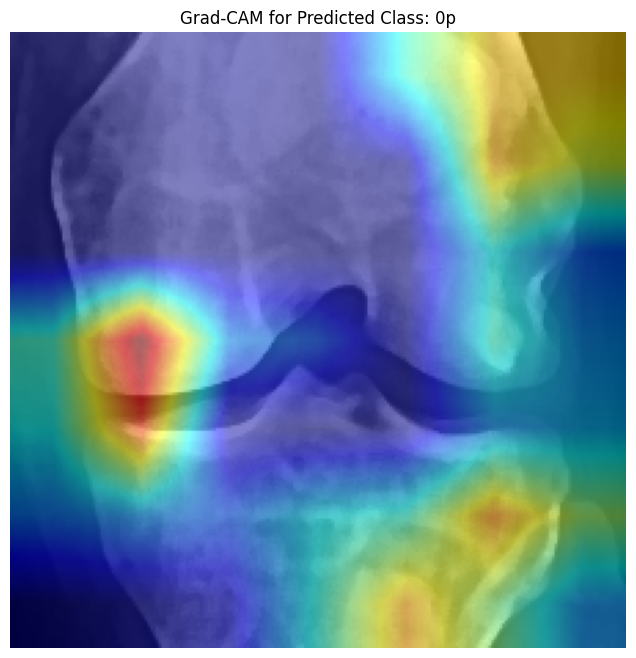

In [39]:
# Corrected image path
image_path = r'C:\Users\C RISHI VARDHAN REDD\Desktop\New folder\0\9003430L.png'

# Run prediction and Grad-CAM visualization
grad_cam, predicted_class_name = predict_image(image_path, model, svm, device, transform, class_names)
plot_gradcam(image_path, grad_cam, predicted_class_name)
